# Adaptation of Adversarial Tasks Tutorial

## Introduction

Natural biological learning occur gradually over time, in a progressive manner. The organism continues to build on past knowledge using new experiences and data, improving their performance in past and future tasks Various methods, broadly referred to as lifelong learning algorithms, have been introduced to mimic this phenomenon [Rusu, et al. (2016)](https://arxiv.org/abs/1606.04671). Specifically, classical machine learning systems exhibit “catastrophic forgetting” when trained sequentially, meaning their performance on the prior tasks drops precipitously upon training on new tasks [McCloskey, et al. (1989)](https://doi.org/10.1016/S0079-7421(08)60536-8). Lifelong learning algorithms attempt to overcome this phenomenon. 


Previous work in lifelong learning falls loosely into two algorithmic camps: (i) continually updating a fixed parametric model as new tasks arrive, and (ii) adding resources as new tasks arrive [Lee, et al. (2019)](https://doi.org/10.24963/ijcai.2019/393). However, it has been shown that many state of the art lifelong learning algorithms are unable to transfer knowledge forward, and fewer are able to transfer knowledge backward [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf). Furthermore, the effects of adversarial tasks in lifelong learning settings have not been thoroughly addressed. It is not uncommon that data between tasks do not follow the same distribution, and task robustness is therefore a desired property in lifelong learning frameworks. 

In this tutorial, we build on the algorithmic framework called "omnidirectional learning". Omnidirectional learning algorithms have demonstrated success in transferring knowledge both forwards and backwards in a variety of scenarios, as described in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf). We investigate the detrimental impacts of learning an adversarial task, and show the effects of domain adaptation methods to alleviate the disruptive effects of divergence between the data probability distribution functions of the tasks.

In [1]:
import numpy as np
import adversarial_adaptation_functions as fn

In [2]:
# Installing pycpd if not avaliable
try:
    import pycpd
except:
    #!pip install pycpd
    import pycpd

**Note:** This notebook tutorial uses functions stored externally within `functions/adversarial_adaptation_functions.py`, to simplify presentation of code. These functions are imported above, along with other libraries.

## Background

### Omnidirectional Learning
In lifelong learning, instead of one task, there is an environment $T$ of (possibly infinitely) many tasks. We consider lifelong learning in "task-aware" scenarios, where the learner is aware of all task identifiers, meaning the hypotheses are of the form $h:\mathcal{X} \times T \rightarrow \mathcal{Y}$.  In this work, we use the omnidirectional forest (ODIF), a decision forest-based variant for ensembling representations described in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf). 

### Evaluation Criteria
There exists various proposed criteria for evaluating transfer in the forward and backwards direction in lifelong learning. One such useful measure is the transfer benefit ratio (TBR) introduced by [Pearl, et al. (2019)](https://dl.acm.org/doi/10.1145/3241036), extending directly from relative efficiency from classical statistics. This idea of a TBR is further generalized with forward and backward extensions in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf), of which we present and incorporate below.   

Transfer efficiency is defined as the ratio of the generalization error of (i) an algorithm that has learned only from data associated with a given task, to (ii) the same learning algorithm that also has access to other data. For notation, $R^t$ be the risk associated with task $t$, $R^t(f_n^t )$ denote the risk on task $t$ of the hypothesis learned by $f_n$ only on task $t$ data, and $R^t(f_n)$ denote the risk on task $t$ of the hypothesis learned on all the data. 

The transfer efficiency of algorithm $ f $ for given task $ t $ with sample size $n$ is

$$\mathsf{TE}_n^t(f) := \mathbb{E}\left[{R^t\left(f(\mathbf{S}_n^t)\right)}\right]/\mathbb{E}\left[{R^t\left(f(\mathbf{S}_n))\right)}\right]
$$ 

We say that algorithm $ f $ has transfer learned for task $t$ with data $\mathbf{S}_n$ if and only if $ \mathsf{TE}_n^t(f) > 1 $. We will be using this evaluation metric to assess the impact of adapted adversarial tasks on lifelong learning.

We can specify the direction of transfer with the forward transfer efficiency $\mathsf{FTE}$ and backward transfer efficiency $\mathsf{BTE}$ extensions to transfer efficiency, defined respectively as: 

$$\mathsf{FTE}_n^t(f) := \mathbb{E} [R^t (f(S_n^{t})] / \mathbb{E}[R^t (f(S_n^{<t}))]$$

$$\mathsf{BTE}_n^t(f) := \mathbb{E} [R^t (f(S_n^{<t})] / \mathbb{E}[R^t (f(S_n))]$$


If $\mathsf{FTE}_n^t(f) > 1$, the algorithm demonstrates positive forward transfer, i.e. data from the current task has been used to improve performance on past tasks. Similarly, if $\mathsf{BTE}_n^t(f) > 1$, the algorithm demonstrates positive backward transfer.

### Adversarial Tasks
In the context of lifelong learning, we define a task $t$ to be adversarial with respect to task $t'$ if the true joint distribution of task $t$ without any form of alignment, has no information about task $t$. In other words, training data from task $t'$ can only add noise for task $t$, and this corresponds to $\mathsf{TE}^t(f_n)<1$.

With the above evaluation criteria, lifelong learning in a simple environment can therefore be demonstrated with the Gaussian XOR distribution and various "adversarial" transformations to the Gaussian XOR distribution.

Gaussian XOR is a two-class classification problem, where:
- Class 0 is drawn from two Gaussians with $\mu = \pm [0.5, 0.5]^T$ and $\sigma^2 = I$.
- Class 1 is drawn from two Gaussians with $\mu = \pm [0.5, -0.5]^T$ and $\sigma^2 = I$.



In [3]:
#more text here

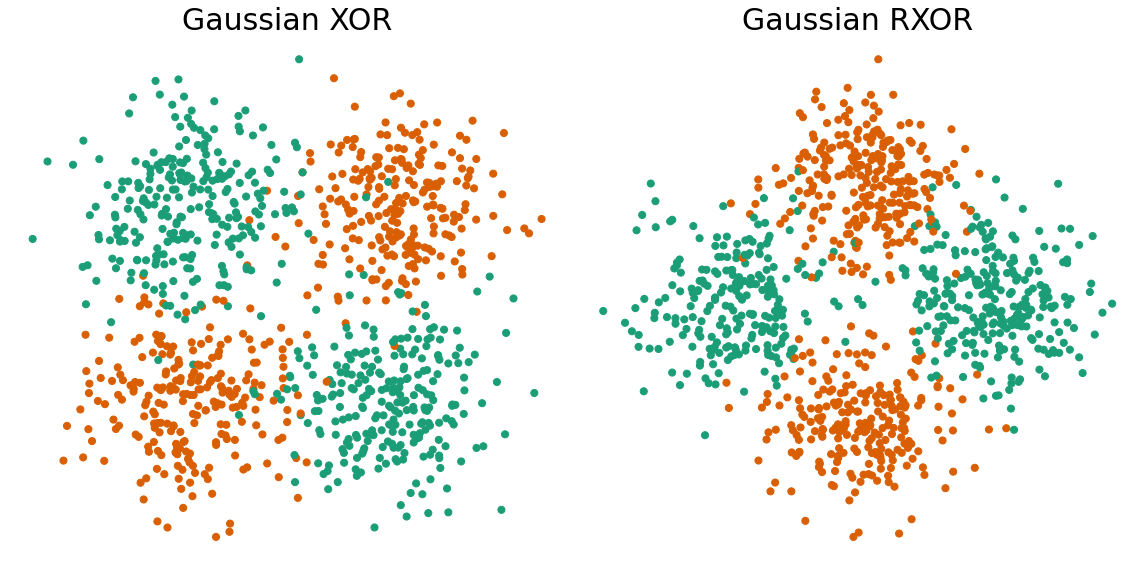

In [4]:
fn.view_rxor()

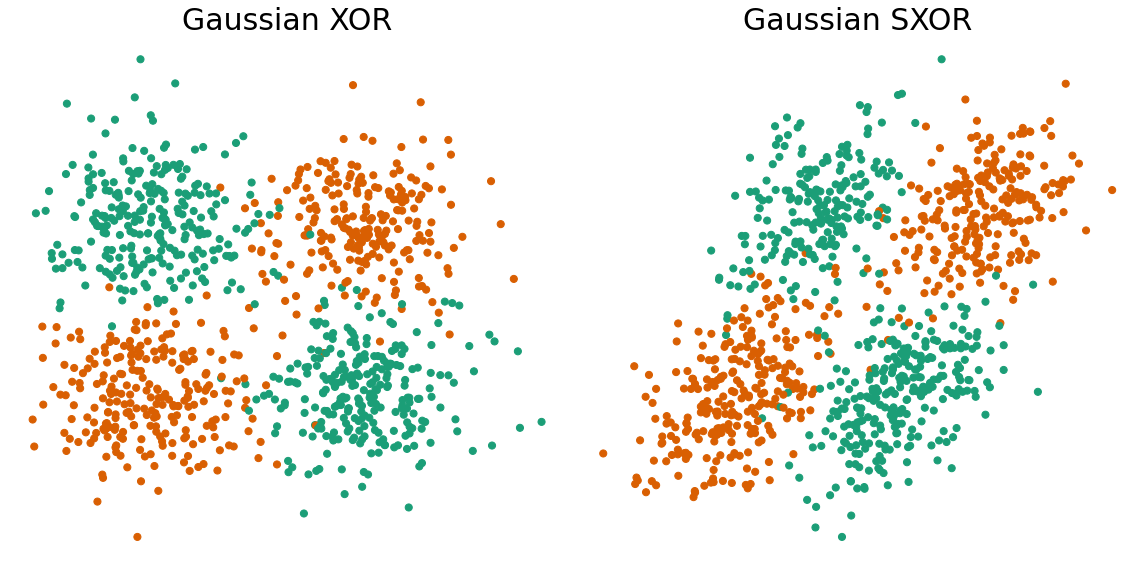

In [5]:
fn.view_sxor()

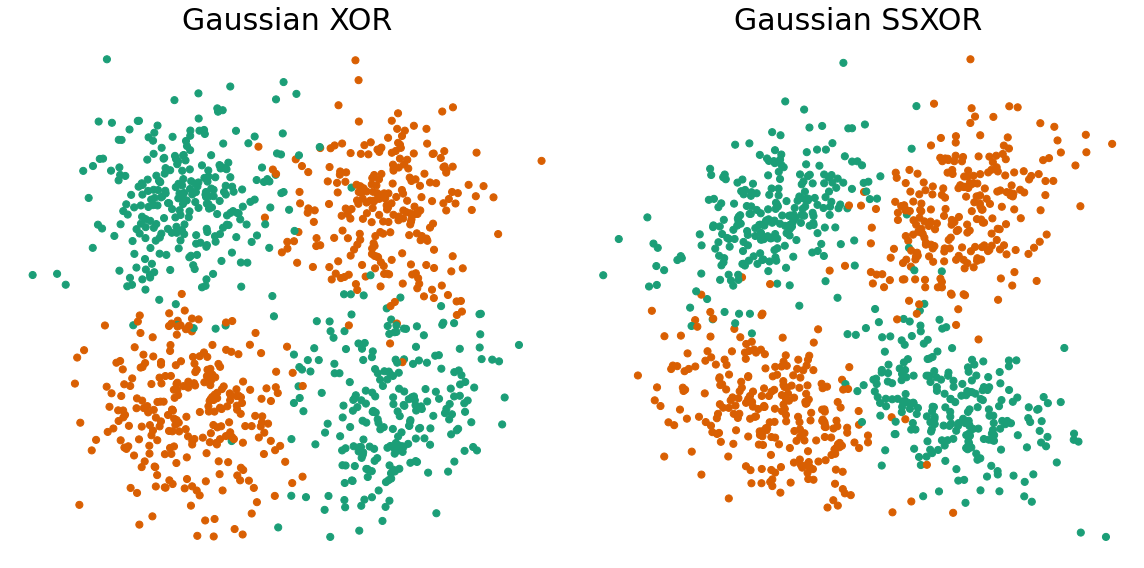

In [6]:
fn.view_ssxor()

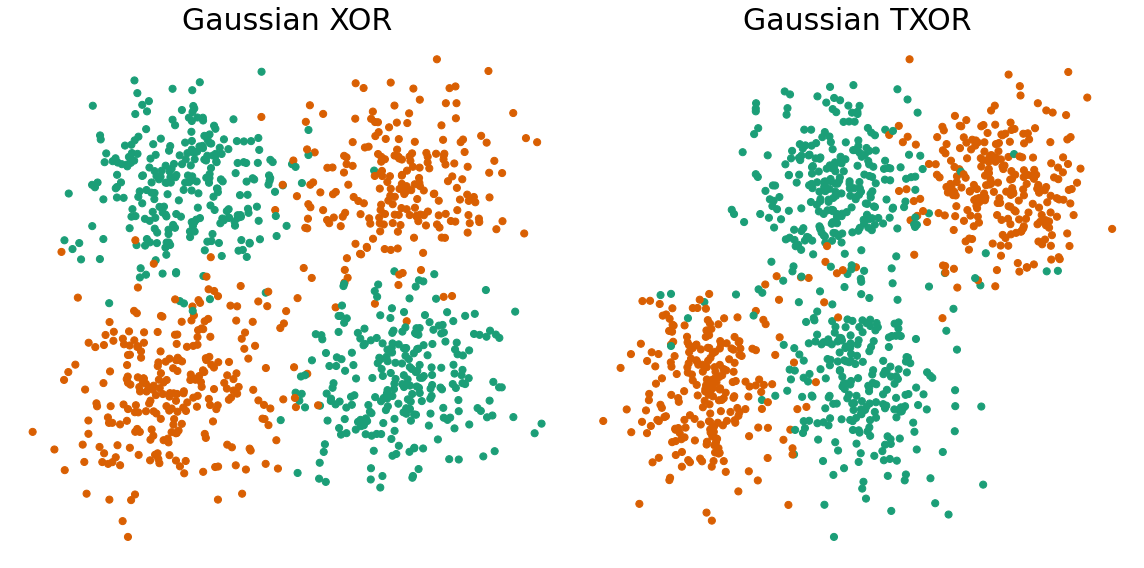

In [7]:
fn.view_txor()

### Domain Adaptation
Adversarial tasks in lifelong learning can be addressed through a domain adaptation perspective. Formally, in domain adaptation problems, one assumes the existence of two distinct joint probability distributions $P_s(\textbf{x}^s, y)$ and $P_t(\textbf{x}^t, y)$, respectively related to a source and a target domains, noted as $\Omega_s$ and $\Omega_t$. The source and target empirical distributions correspond to two unaligned tasks, and this domain drift can be seen as an unknown nonlinear transformation of the input space. We also assume that this transformation preserves the conditional distribution, i.e.

$$P_s(y|\textbf{x}^s) = P_t(y|T(\textbf{x}^s))$$

This means that the label information is preserved by the transformation, and with "task-aware" lifelong learning, we can take advantage of class labels to regularize and better recover the transformation during training.

# RXOR Experiment

In [8]:
#main hyperparameters
angle_sweep = range(0,91,10)
task1_sample = 100
task2_sample = 100
mc_rep = 100

In [9]:
mean_te1 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


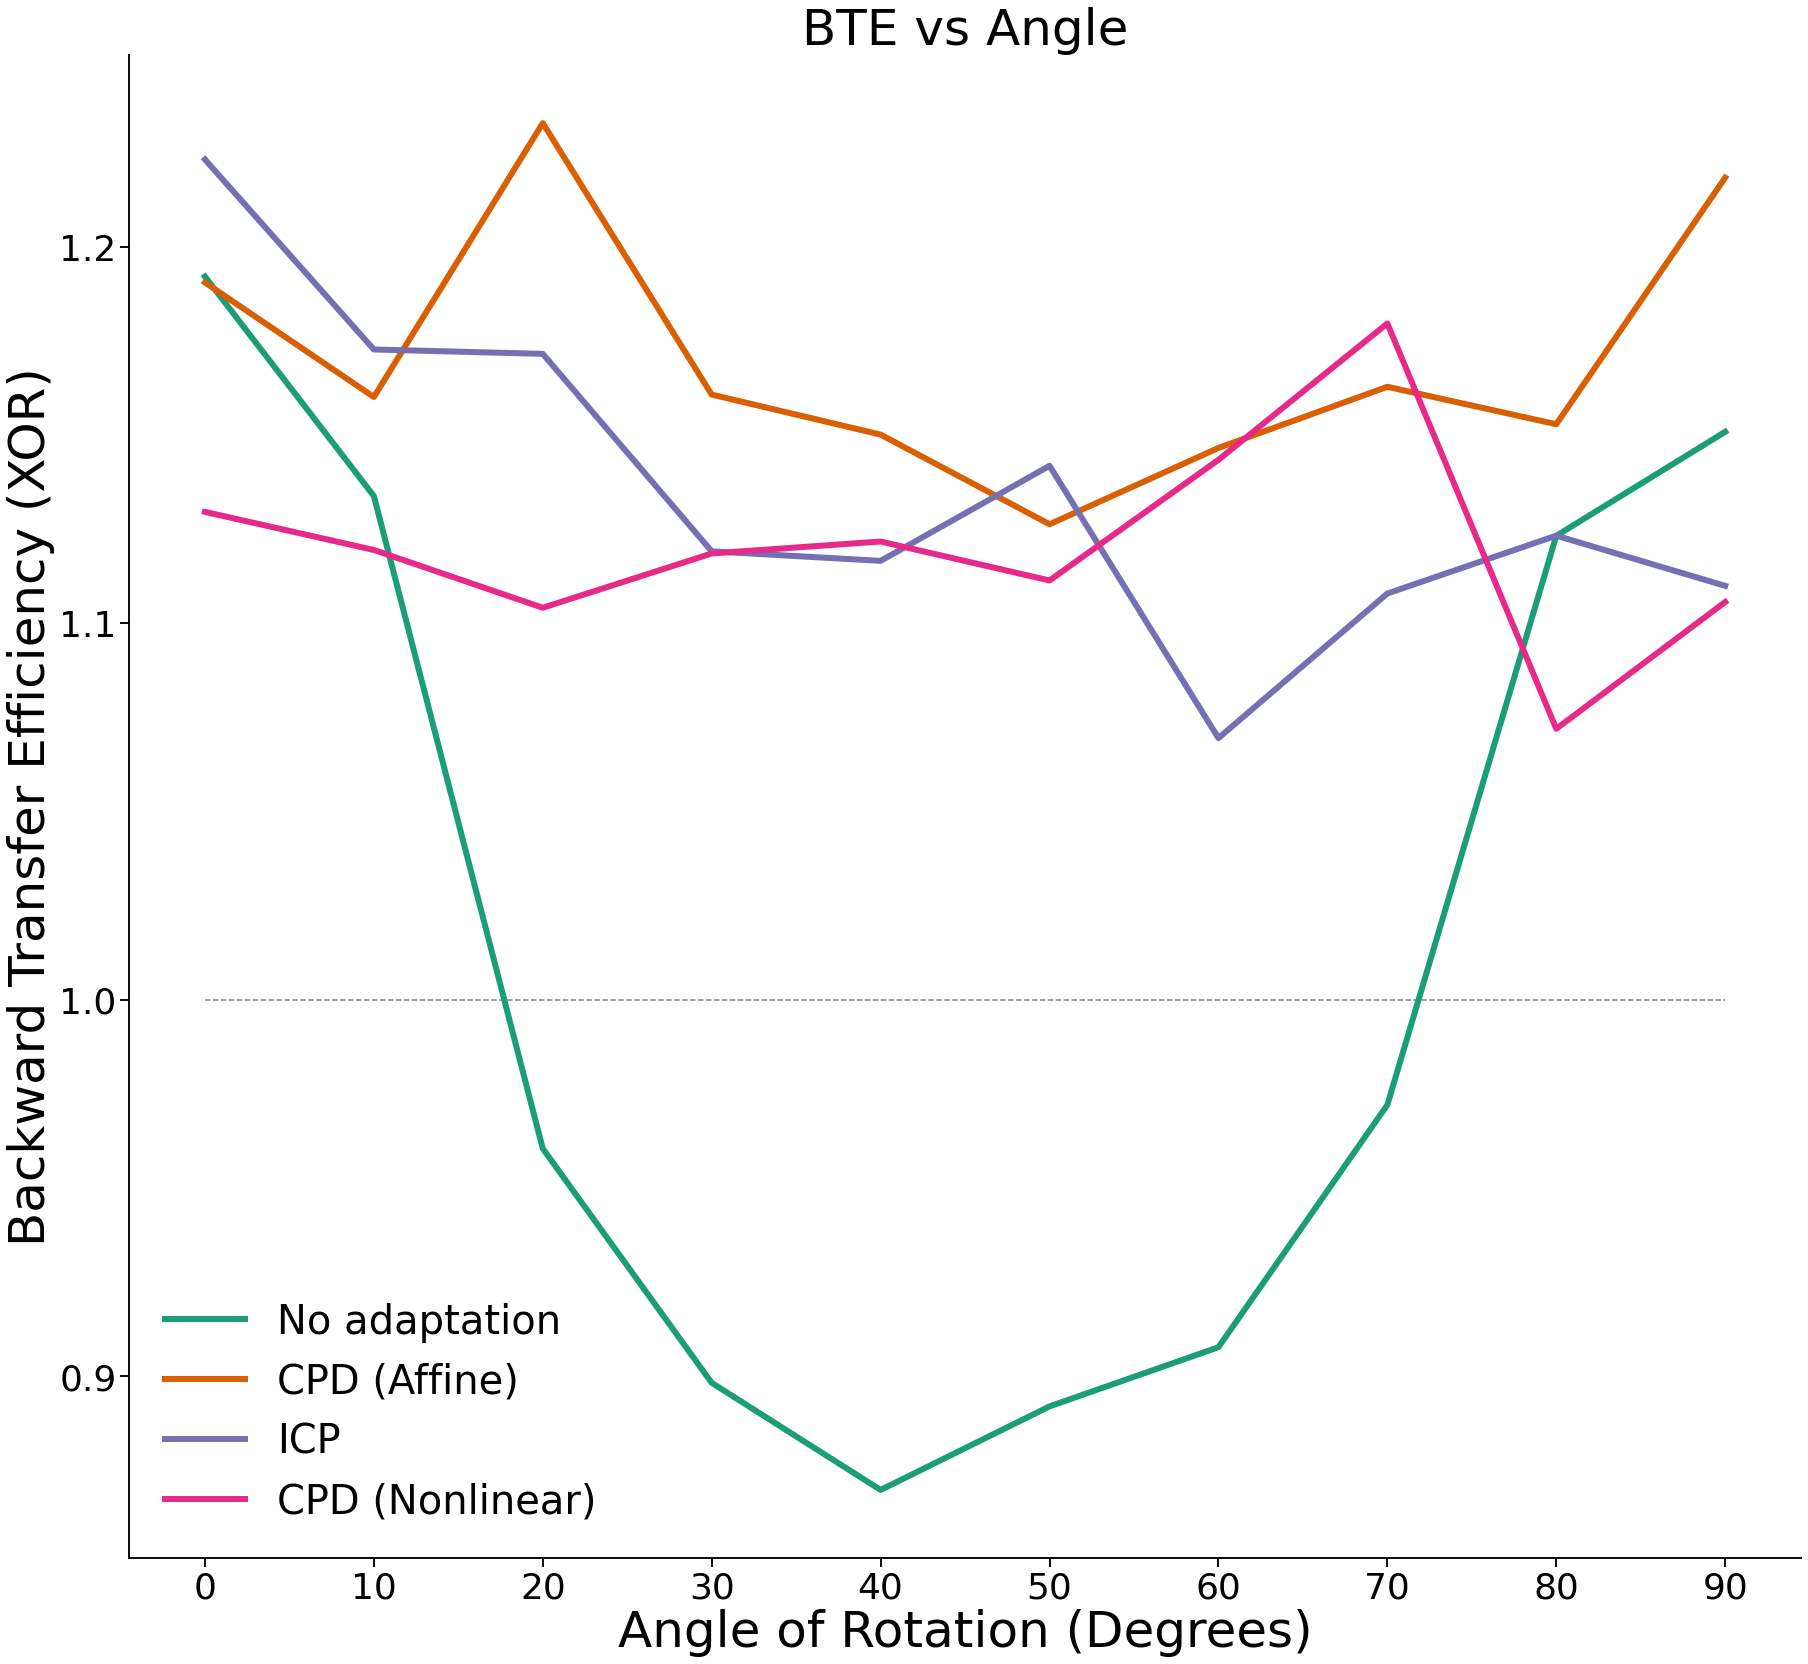

In [10]:
fn.plot_bte_v_angle(angle_sweep,  mean_te1, mean_te2, mean_te3, mean_te4)

# SXOR Experiment

In [11]:
#main hyperparameters
shear_sweep = [x * 10**e for e in range(-2, 3) for x in [1, 2, 5]];
task1_sample = 100
task2_sample = 100
mc_rep = 100

In [12]:
mean_te1 = fn.bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = fn.bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = fn.bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = fn.bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Usin

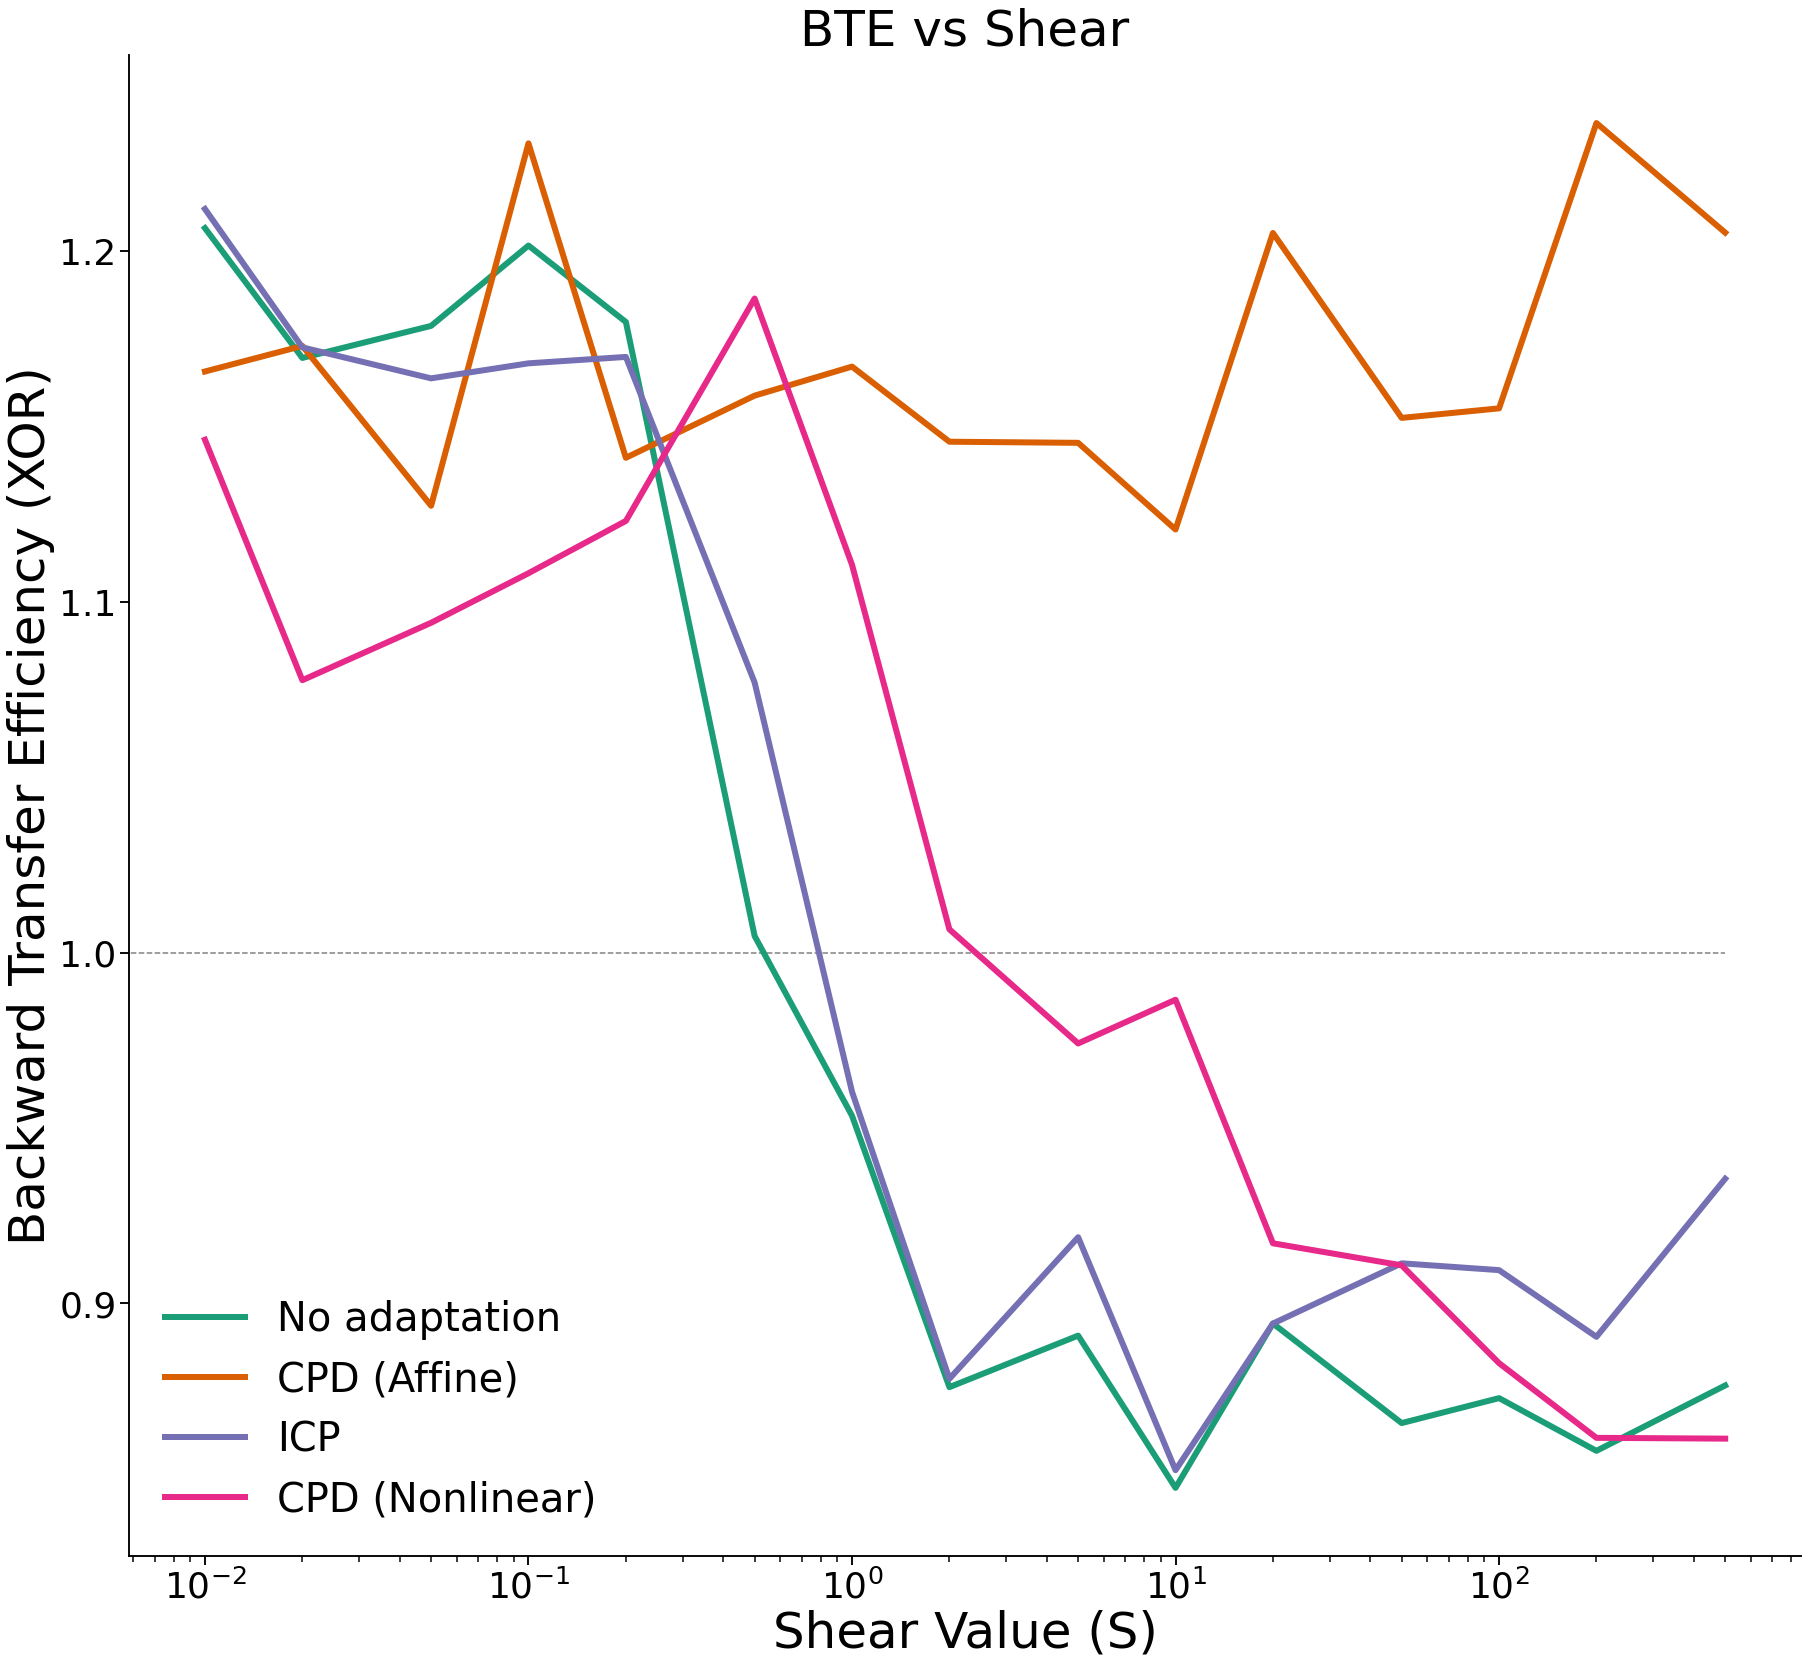

In [13]:
fn.plot_bte_v_shear(shear_sweep,  mean_te1, mean_te2, mean_te3, mean_te4)

# SSXOR Experiment

In [14]:
#main hyperparameters
shear_sweep = [x * 10**e for e in range(-2, 3) for x in [1, 2, 5]];
task1_sample = 100
task2_sample = 100
mc_rep = 100

In [15]:
mean_te1 = fn.bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = fn.bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = fn.bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = fn.bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Usin

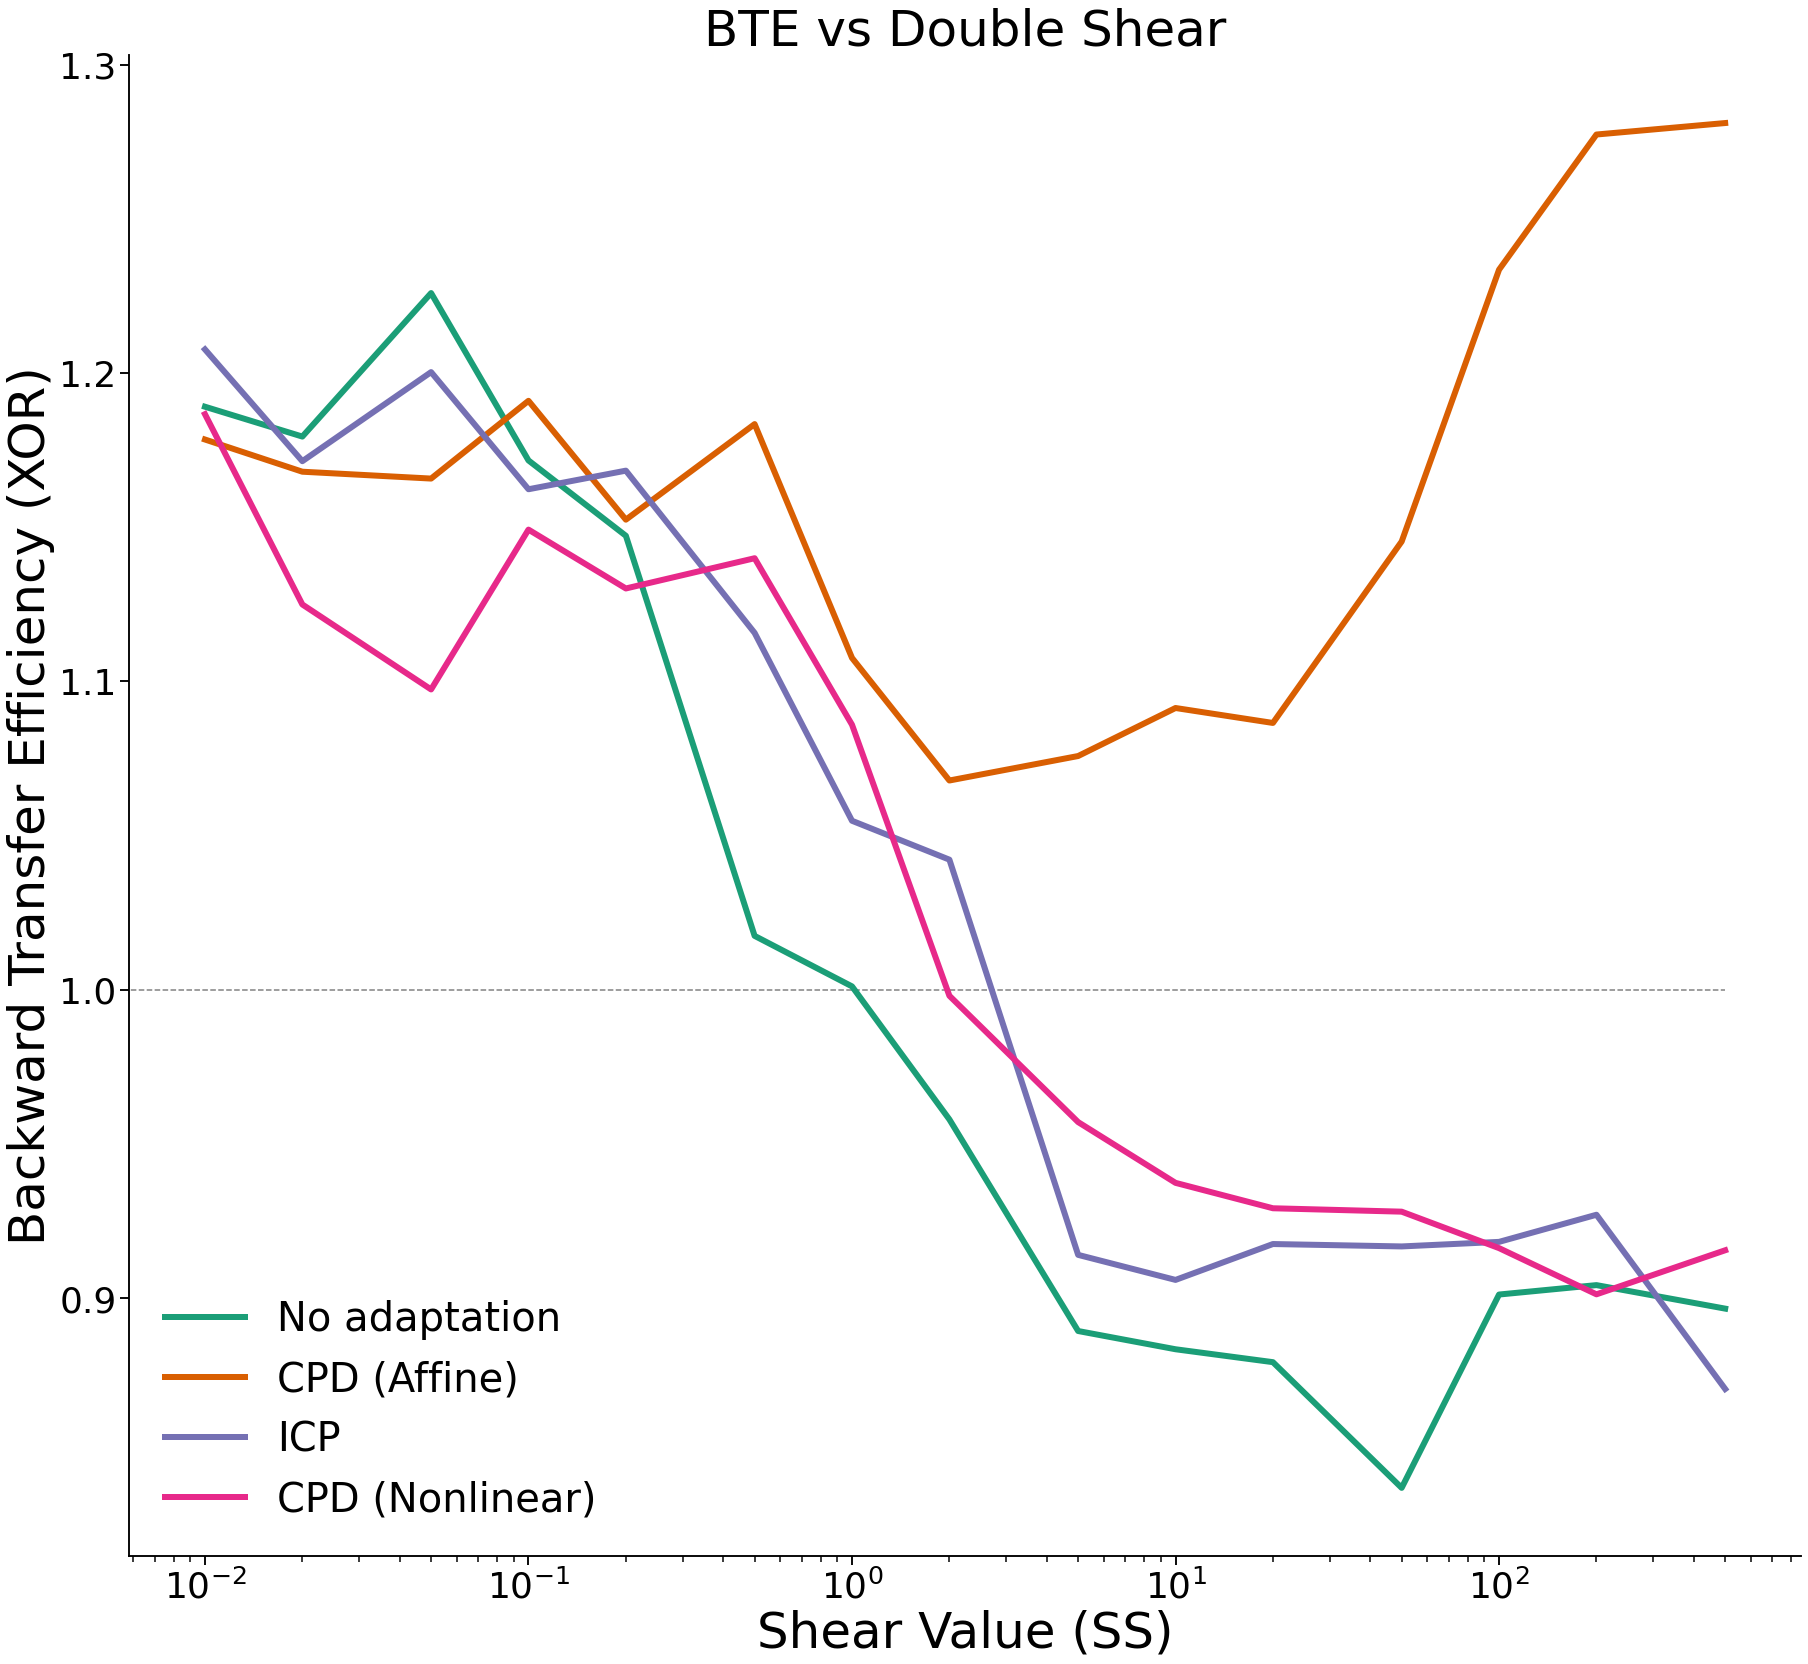

In [16]:
fn.plot_bte_v_double_shear(shear_sweep,  mean_te1, mean_te2, mean_te3, mean_te4)

# TXOR Experiment

In [17]:
#main hyperparameters
trans_sweep = np.arange(0, 2.25, 0.25);
task1_sample = 100
task2_sample = 100
mc_rep = 100

In [18]:
mean_te1 = fn.bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = fn.bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = fn.bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = fn.bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]

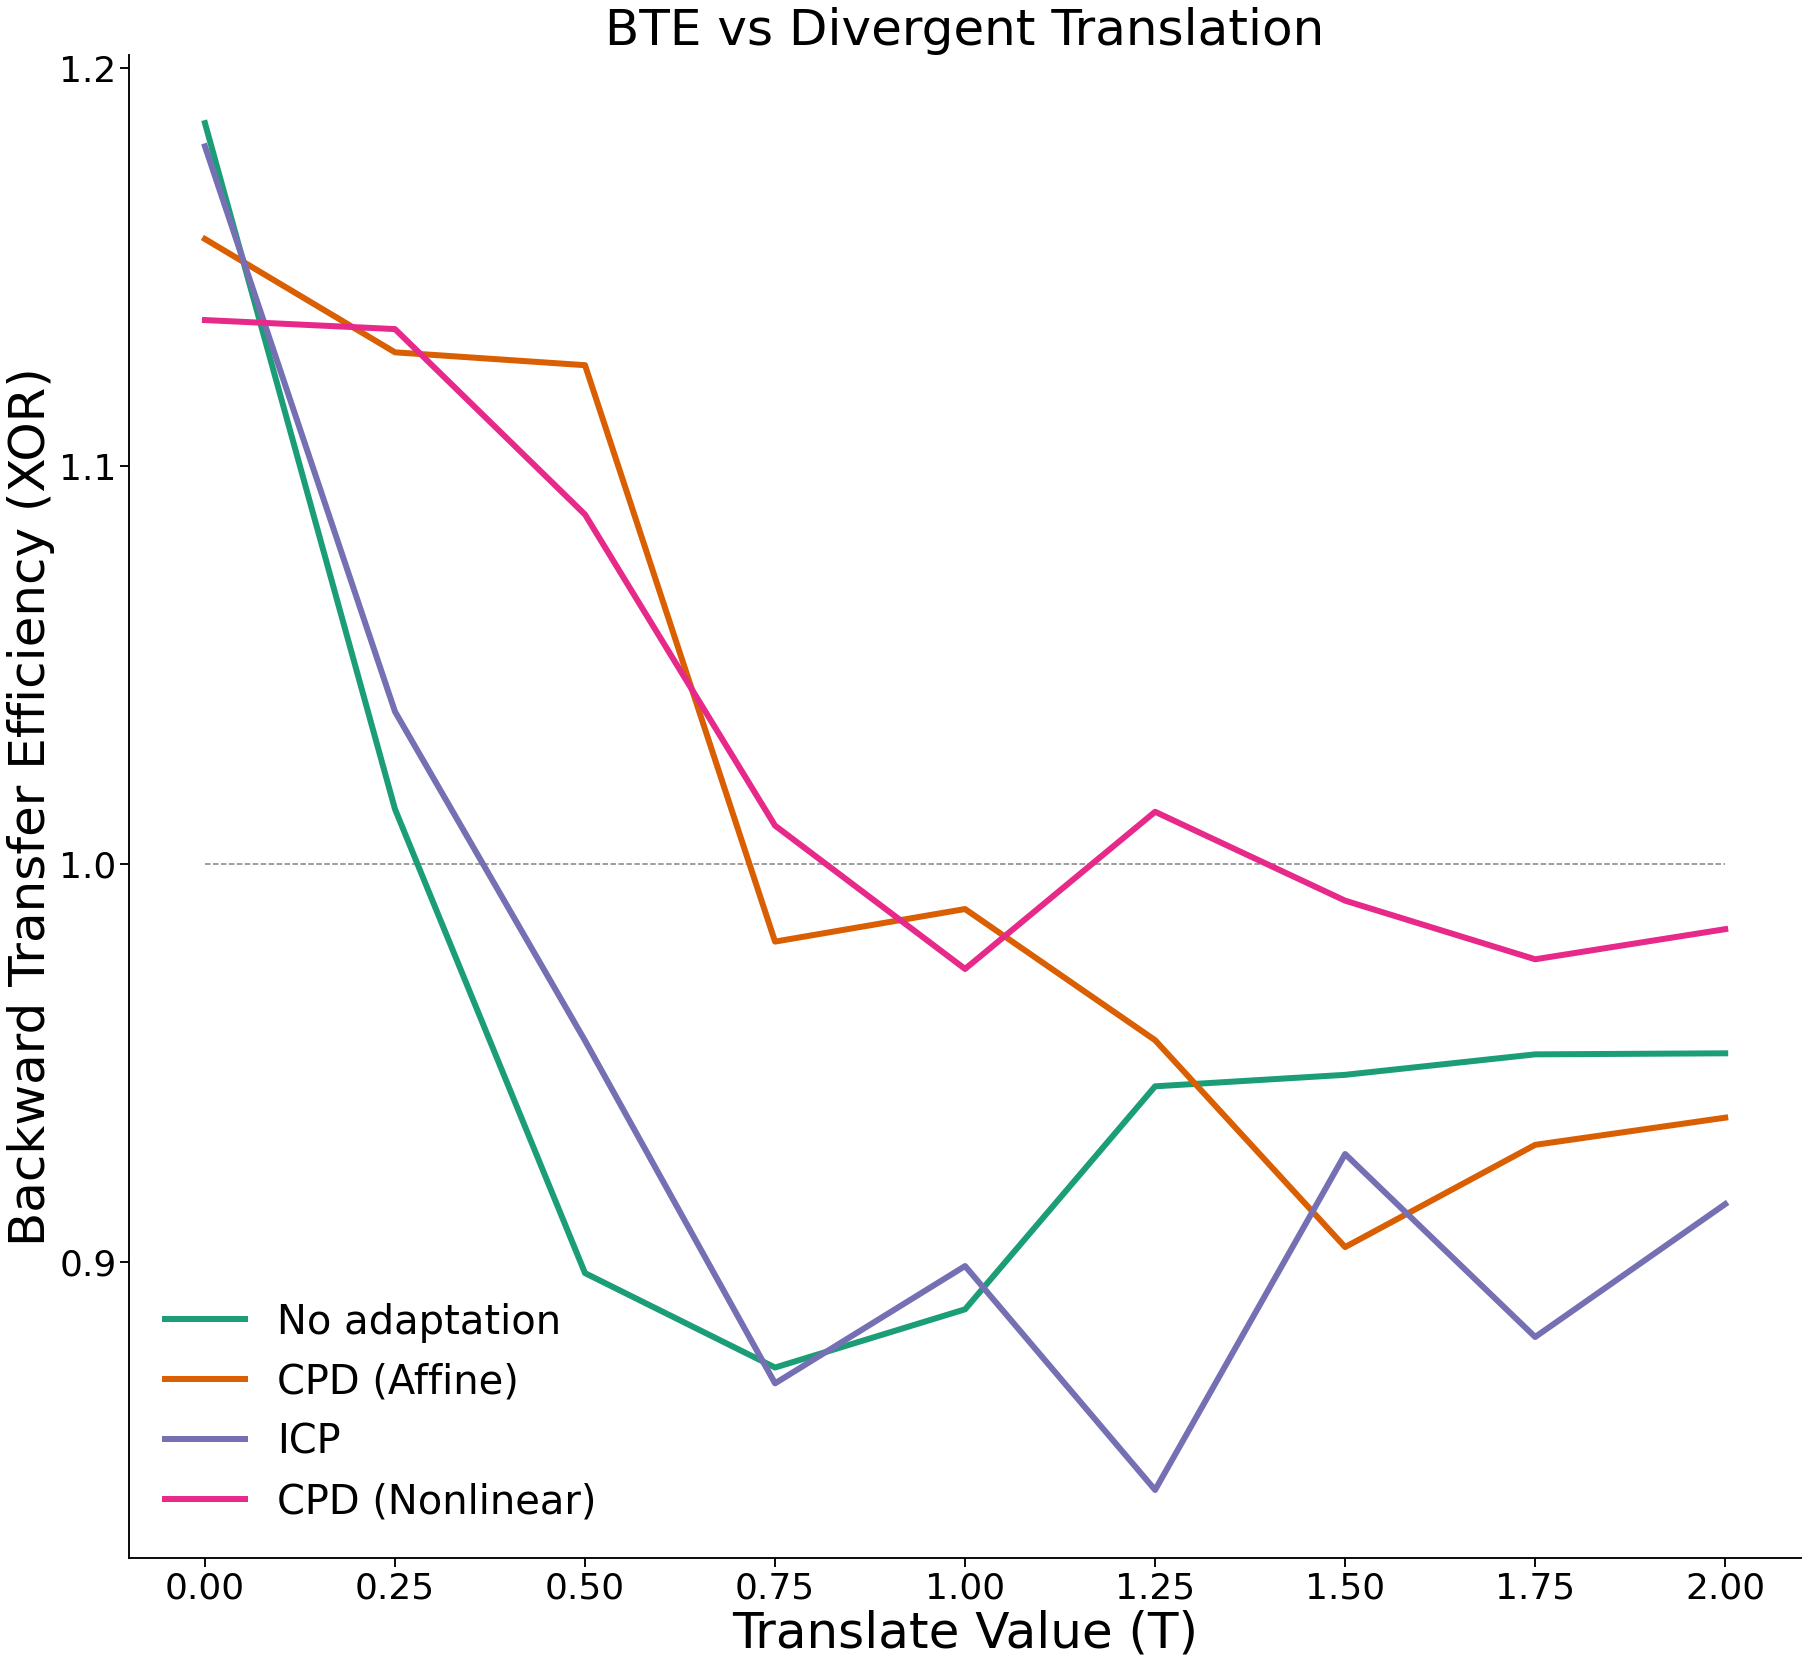

In [19]:
fn.plot_bte_v_translate(trans_sweep,  mean_te1, mean_te2, mean_te3, mean_te4)